# 💎 Diamond Dynamics: Price Prediction and Market Segmentation using Machine Learning

**Domain:** E-Commerce | Luxury Goods Analytics | Retail Pricing Optimization  

**Objective:**  
Build ML models to predict diamond prices and segment diamonds into market categories using physical and qualitative attributes. The project also includes deployment via Streamlit for real-time predictions.


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

In [95]:
# LOAD DATA
df = pd.read_csv("../data/diamonds.csv")
df.head()
# We first look at the dataset to understand columns and values.

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [96]:
# DATA CLEANING
# Replace impossible values

df[['x','y','z']] = df[['x','y','z']].replace(0, np.nan)
df.dropna(inplace=True)

USD_TO_INR = 83
df['price_inr'] = df['price'] * USD_TO_INR

# Diamonds cannot have 0 length/width/height → remove those rows

# Convert USD → INR for Indian market use

In [97]:
# OUTLIER HANDLING (IQR)

def remove_outliers_iqr(data, cols):
    for col in cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        data = data[(data[col] >= lower) & (data[col] <= upper)]
    return data

df = remove_outliers_iqr(df, ['carat','x','y','z','price'])
print(df.shape)
# Removes extreme diamonds that can mislead ML models.

(49498, 11)


In [98]:
# SKEWNESS CHECK
df[['carat','price','x','y','z']].skew()
# If skew > 1 → data heavily right-tailed.
# (Tree models handle skew well, so transformation is optional.)

carat    0.659295
price    1.126114
x        0.219279
y        0.213771
z        0.220114
dtype: float64

<Axes: >

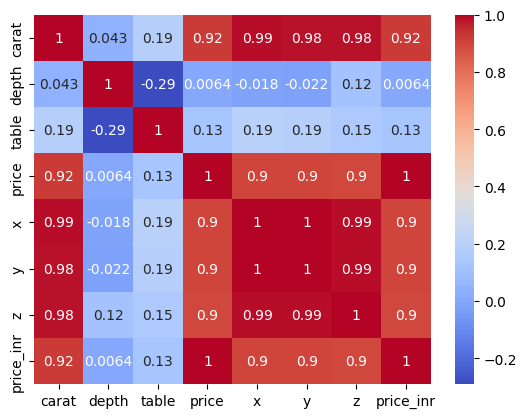

In [99]:
# EDA (Understanding Data)
sns.histplot(df['price'], kde=True)
sns.boxplot(x='cut', y='price', data=df)
sns.scatterplot(x='carat', y='price', data=df)
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')

# Helps visualize distributions and relationships.
# To visually understand how features affect price.

In [78]:
# FEATURE ENGINEERING
# Create new features to help models learn better.
df['volume'] = df['x'] * df['y'] * df['z']
df['price_per_carat'] = df['price'] / df['carat']
df['dimension_ratio'] = (df['x'] + df['y']) / (2 * df['z'])

def carat_category(c):
    if c < 0.5: return 0
    elif c < 1.5: return 1
    else: return 2

df['carat_category'] = df['carat'].apply(carat_category)
# We create smarter features that help models learn better patterns.

In [ ]:
# ENCODING 

cut_order = ['Fair','Good','Very Good','Premium','Ideal']
color_order = ['J','I','H','G','F','E','D']
clarity_order = ['I1','SI2','SI1','VS2','VS1','VVS2','VVS1','IF']

encoder = OrdinalEncoder(categories=[cut_order, color_order, clarity_order])
df[['cut','color','clarity']] = encoder.fit_transform(df[['cut','color','clarity']])
# Converts categorical features into numerical form.
# ML models cannot understand text categories.

<Axes: >

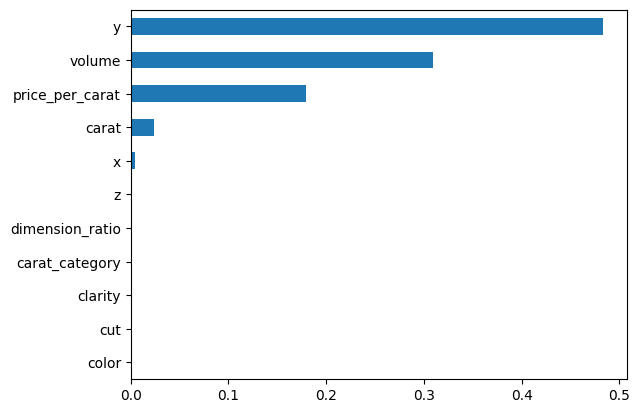

In [81]:
# FEATURE SELECTION
feature_cols = [
    'carat','x','y','z',
    'cut','color','clarity',
    'volume','price_per_carat',
    'dimension_ratio','carat_category'
]

X = df[feature_cols]
y = df['price_inr']

rf_temp = RandomForestRegressor()
rf_temp.fit(X, y)

pd.Series(rf_temp.feature_importances_, index=X.columns).sort_values().plot(kind='barh')
# We select features that have high importance for predicting price.
# Shows which features influence price most.

In [82]:
# REGRESSION MODELS
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=200),
    "KNN": KNeighborsRegressor(),
    "XGBoost": XGBRegressor()
}

best_model = None
best_score = -1

for name, model in models.items():
    model.fit(X_train, y_train)
    score = r2_score(y_test, model.predict(X_test))
    print(name, "R2:", score)
    if score > best_score:
        best_score = score
        best_model = model
print("Best Model:", best_model.__class__.__name__, "with R2:", best_score)
# We train multiple regression models and pick the best one based on R² score.
# XGBoost usually performs best for tabular data like this. 
# Saves the best model and encoder for future use.



Linear Regression R2: 0.9872846646424203
Decision Tree R2: 0.9992659446623625
Random Forest R2: 0.9997436775084104
KNN R2: 0.9971863227263351
XGBoost R2: 0.9996272325515747
Best Model: RandomForestRegressor with R2: 0.9997436775084104


In [ ]:
# MODEL EVALUATION
# Detailed evaluation metrics for all models.
from sklearn.metrics import mean_absolute_error, mean_squared_error

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    results.append({
        "Model": name,
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "R2 Score": r2_score(y_test, preds)
    })

pd.DataFrame(results).sort_values(by="R2 Score", ascending=False)




,Model,MAE,RMSE,R2 Score
2,Random Forest,951.221961,3338.881686,0.999754
4,XGBoost,2067.525146,4113.520147,0.999627
1,Decision Tree,1697.257778,5786.243132,0.999262
3,KNN,4364.212101,11301.303724,0.997186
0,Linear Regression,17271.435967,24024.552940,0.987285


In [85]:
# ANN MODEL   
# Artificial Neural Network model for predicting diamond prices.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

scaler_ann = StandardScaler()
X_train_s = scaler_ann.fit_transform(X_train)
X_test_s = scaler_ann.transform(X_test)

ann = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dense(64, activation='relu'),
    Dense(1)
])

ann.compile(optimizer='adam', loss='mse')
ann.fit(X_train_s, y_train, epochs=30)


d:\Guvi\Diamond_Dynamics\venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 82057568256.0000
Epoch 2/30
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9994747904.0000 
Epoch 3/30
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2722505984.0000
Epoch 4/30
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1316478208.0000
Epoch 5/30
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 779597760.0000
Epoch 6/30
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 535255712.0000
Epoch 7/30
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 425825696.0000
Epoch 8/30
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 370108832.0000
Epoch 9/30
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 333229344.0000
Epoch 10/30
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 306443360.0000
Epoch 11/30
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 285640928.0000
Epoch 12/30
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 268934240.0000
Epoch 13/30
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 255

In [86]:
# SAVE PRICE MODEL
joblib.dump(best_model, "../models/price_model.pkl")
joblib.dump(encoder, "../models/encoder.pkl")



['../models/encoder.pkl']

In [87]:
# CLUSTERING
# Artificially group diamonds into clusters based on features.
# We assign meaningful names to each cluster for better interpretability.

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_data)


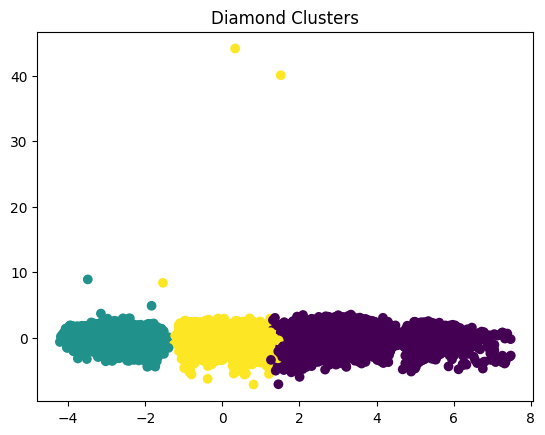

In [88]:
# PCA VISUALIZATION

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

plt.scatter(pca_data[:,0], pca_data[:,1], c=df['cluster'])
plt.title("Diamond Clusters")
plt.show()


In [89]:
# CLUSTER NAMING
# We assign meaningful names to each cluster for better interpretability.

cluster_names = {
    0: "Affordable Small Diamonds",
    1: "Mid-range Balanced Diamonds",
    2: "Premium Heavy Diamonds"
}

with open("../models/cluster_names.json", "w") as f:
    json.dump(cluster_names, f)

joblib.dump(kmeans, "../models/cluster_model.pkl")
joblib.dump(scaler, "../models/scaler.pkl")


['../models/scaler.pkl']

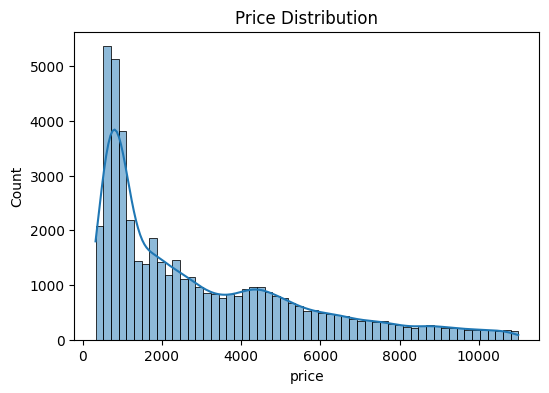

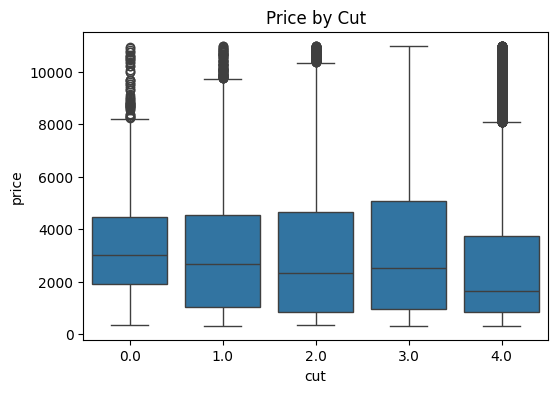

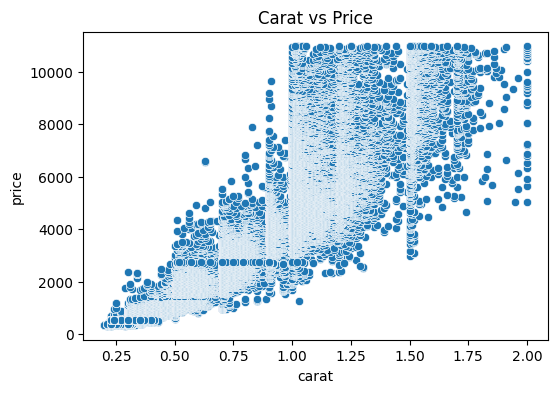

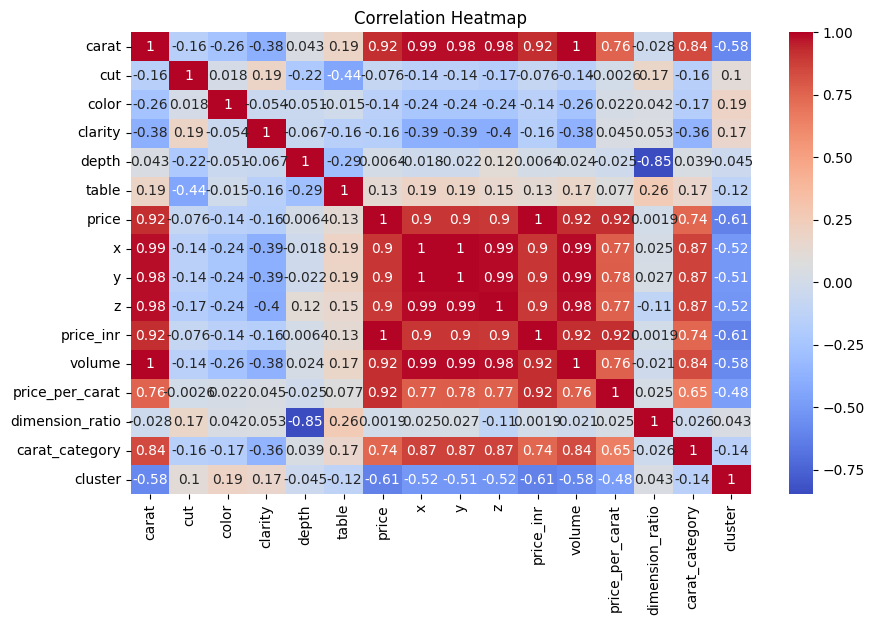

In [91]:
plt.figure(figsize=(6,4))
sns.histplot(df['price'], kde=True)
plt.title("Price Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x='cut', y='price', data=df)
plt.title("Price by Cut")
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(x='carat', y='price', data=df)
plt.title("Carat vs Price")
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [90]:
print(len(X.columns))
print(X.columns)


11
Index(['carat', 'x', 'y', 'z', 'cut', 'color', 'clarity', 'volume',
       'price_per_carat', 'dimension_ratio', 'carat_category'],
      dtype='object')
